In [ ]:
%pip install langchain
%pip install transformers
%pip install sentence-transformers
#%pip install bitsandbytes
%pip install pandas
#%pip install python-dotenv
%pip install -U langchain-community faiss-gpu langchain-openai tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders.merge import MergedDataLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, TokenTextSplitter, CharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
# Set seed for vector database
random.seed(42)
torch.manual_seed(42)

# Check device
has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(device)

if has_gpu:
    torch.cuda.manual_seed_all(42)

cpu


cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


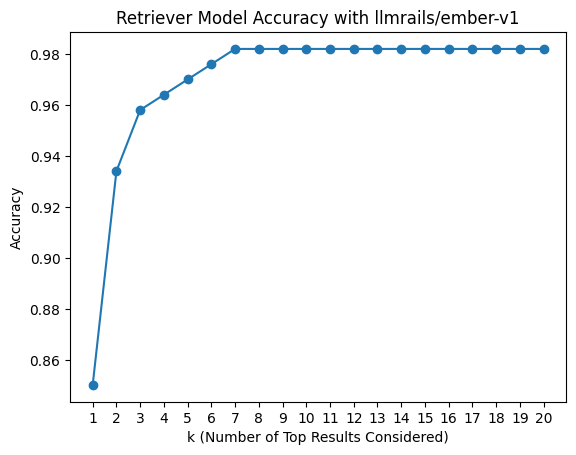

In [ ]:

# Load data
loader_1 = CSVLoader(
    file_path='processed_data_part1.csv',
    metadata_columns=['PMID', 'Title', 'Authors', 'Publication Date', 'DOI'])
loader_2 = CSVLoader(
    file_path='processed_data_part2.csv',
    metadata_columns=['PMID', 'Title', 'Authors', 'Publication Date', 'DOI'])

loader_all = MergedDataLoader(loaders=[loader_1, loader_2])
docs_all = loader_all.load()

eval_data = pd.read_csv('questions_answers.csv')
eval_data.rename(columns={eval_data.columns[0]: 'PMID'}, inplace=True)


# Evaluate
def evaluate_and_plot(model_name, tokenizer, model, plot_title, file_name):
    # Define embedding model
    model_kwargs = {'device': device}
    encode_kwargs = {'normalize_embeddings': True}
    embed_model = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs)

    # Apply text splitting into chunks to prevent truncation of longer abstracts
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def token_len(text):
        tokens = tokenizer.tokenize(text)
        tokens_length = len(tokens)

        return tokens_length

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=400,
                                                                         chunk_overlap=100,)
    chunked_docs = text_splitter.split_documents(docs_all)


    # Set up Faiss vector database
    db = FAISS.from_documents(chunked_docs, embedding=embed_model)

    #Save embeddings locally
    index_path = f"faiss_indices/{model_name}"
    db.save_local(index_path)

    # Extract gold labels and queries
    gold_pmids = eval_data['PMID'].to_list()
    eval_queries = eval_data['QUESTION'].to_list()

    accuracies = []

    for k in range(1, 21):
        retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})
        matches = 0

        for query, gold_label in zip(eval_queries, gold_pmids):
            top_k_results = retriever.get_relevant_documents(query)
            retrieved_pmids = [int(result.metadata['PMID']) for result in top_k_results]

            if gold_label in retrieved_pmids:
                matches += 1

        accuracy = matches / len(eval_queries)
        accuracies.append(accuracy)

    # Save accuracies to a text file
    file_path = file_name.replace('.png', '.txt')
    with open(file_path, 'w') as f:
        for accuracy in accuracies:
            f.write(f"{accuracy}\n")

    # Plotting the results
    plt.plot(range(1, 21), accuracies, marker='o')
    plt.xlabel('k (Number of Top Results Considered)')
    plt.ylabel('Accuracy')
    plt.title(plot_title)
    plt.xticks(range(1, 21))

    plt.savefig(file_name)


# List of models to evaluate
models_to_evaluate = [    # {
          # #required too much memory, was too large to be executed on Colab
    #     'model_name': 'Muennighoff/SGPT-125M-weightedmean-nli-bitfit',
    #     'tokenizer': AutoTokenizer.from_pretrained("Muennighoff/SGPT-125M-weightedmean-nli-bitfit"),
    #     'model': SentenceTransformer("Muennighoff/SGPT-5.8B-weightedmean-msmarco-specb-bitfit"),
    #     'plot_title': 'Retriever Model Accuracy with SGPT-125M',
    #     'file_name': 'retriever_accuracy_Muennighoff_SGPT-125M-weightedmean-nli-bitfit.png'
    # },
    # {
          # #extremely bad results
    #     'model_name': 'dmis-lab/biobert-base-cased-v1.1',
    #     'tokenizer': AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1"),
    #     'model': AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1"),
    #     'plot_title': 'Retriever Model Accuracy with BioBERT',
    #     'file_name': 'retriever_accuracy_dmis-lab_biobert-base-cased-v1.1.png'
    # },
    # {
          # #92% accuracy at k=3
    #     'model_name': 'intfloat/e5-base-v2',
    #     'tokenizer': AutoTokenizer.from_pretrained("intfloat/e5-base-v2"),
    #     'model': SentenceTransformer("intfloat/e5-base-v2"),
    #     'plot_title': 'Retriever Model Accuracy with e5-base-v2',
    #     'file_name': 'retriever_accuracy_intfloat_e5-base-v2.png'
    # },
    # {
    #      #best results so far: 98% accuracy at k=3
    #     'model_name': 'BAAI/bge-base-en-v1.5',
    #     'tokenizer': AutoTokenizer.from_pretrained("BAAI/bge-base-en-v1.5"),
    #     'model': SentenceTransformer("BAAI/bge-base-en-v1.5"),
    #     'plot_title': 'Retriever Model Accuracy with bge-base-en-v1.5',
    #     'file_name': 'retriever_accuracy_BAAI_bge-base-en-v1.5.png'
    # },
    # {
    #     #second best so far: 96% accuracy at k=3
    #     'model_name': 'llmrails/ember-v1',
    #     'tokenizer': AutoTokenizer.from_pretrained("llmrails/ember-v1"),
    #     'model': SentenceTransformer("llmrails/ember-v1"),
    #     'plot_title': 'Retriever Model Accuracy with llmrails/ember-v1',
    #     'file_name': 'retriever_accuracy_llmrails_ember-v1.png'
    # },
    {
        'model_name': 'sentence-transformers/all-MiniLM-L6-v2',
        'tokenizer': AutoTokenizer.from_pretrained("all-MiniLM-L6-v2"),
        'model': SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2"),
        'plot_title': 'Retriever Model Accuracy with all-MiniLM-L6-v2',
        'file_name': 'retriever_accuracy_sentence-transformers_all-MiniLM-L6-v2.png'
    },
    {
        'model_name': 'jamesgpt1/sf_model_e5',
        'tokenizer': AutoTokenizer.from_pretrained("jamesgpt1/sf_model_e5"),
        'model': SentenceTransformer("jamesgpt1/sf_model_e5"),
        'plot_title': 'Retriever Model Accuracy with sf_model_e5',
        'file_name': 'retriever_accuracy_jamesgpt1_sf_model_e5.png'
    },
    # {
    #     'model_name': 'thenlper/gte-base',
    #     'tokenizer': AutoTokenizer.from_pretrained("thenlper/gte-base"),
    #     'model': SentenceTransformer("thenlper/gte-base"),
    #     'plot_title': 'Retriever Model Accuracy with gte-base',
    #     'file_name': 'retriever_accuracy_thenlper_gte-base.png'
    # },

]


# Loop over the models
for model_info in models_to_evaluate:
    evaluate_and_plot(model_info['model_name'], model_info['tokenizer'], model_info['model'], model_info['plot_title'], model_info['file_name'])

